# Classification Tests

spiegazione test

### Imports

In [1]:
import re
import xml.etree.ElementTree as ET
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import it_core_news_sm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import svm
import pandas as pd
import numpy as np
import collections
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
# Skopt functions
from sklearn.metrics import make_scorer, f1_score, recall_score
from skopt import BayesSearchCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from skopt import gp_minimize # Bayesian optimization using Gaussian Processes
from skopt.space import Real, Categorical, Integer
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
import matplotlib.pyplot as plt
from matplotlib.widgets import Cursor
from matplotlib.ticker import FuncFormatter
import seaborn as sns

In [2]:
#nltk.download('punkt')

## Classes

In [3]:
class CarWordsHandler:
    # https://github.com/n8barr/automotive-model-year-data
    def __init__(self, cars_file):
        self.brands_list = set()
        self.models_list = set()
        f = open(cars_file, "r")
        cars_list = f.read().splitlines()
        for i in range(len(cars_list)):
            brand = cars_list[i].split(',')[0][1:].lower()
            model = cars_list[i].split(',')[1][0:-1].lower()
            self.brands_list.add(brand)
            self.models_list.add(model)
        # remove some useless models
        self.models_list.remove('i')
        #self.models_list.remove('gli')
        #self.models_list.remove('estate')
        self.brands_list = list(self.brands_list)
        self.models_list = list(self.models_list)
        self.brands_list.sort()
        self.models_list.sort()
    
    # binary search to get if a word is a brand 
    def isBrand(self, word):
        word = word.lower()
        first = 0
        last = len(self.brands_list) -1
        while first < last:
            mid = int((last + first) / 2)
            if word == self.brands_list[mid]:
                return True
            elif word < self.brands_list[mid]:
                last = mid
            elif word > self.brands_list[mid]:
                first = mid
            if last-first == 1:
                if self.brands_list[first] == word or self.brands_list[last] == word:
                    return True
                else:
                    return False
    # binary search to get if a word is a brand 
    def isModel(self, word):
        word = word.lower()
        first = 0
        last = len(self.models_list) -1
        while first < last:
            mid = int((last + first) / 2)
            if word == self.models_list[mid]:
                return True
            elif word < self.models_list[mid]:
                last = mid
            elif word > self.models_list[mid]:
                first = mid
            if last-first == 1:
                if self.models_list[first] == word or self.models_list[last] == word:
                    return True
                else:
                    return False

In [4]:
a = CarWordsHandler('resources/cars.txt')
a.models_list
a.isModel('e 110')

False

## Functions

In [5]:
# encoding issues
def correctEncodings(comment):
    fin_comment = comment
    fin_comment = re.sub('Ã¨', 'è', fin_comment)
    fin_comment = re.sub('Ã©', 'é', fin_comment)
    fin_comment = re.sub('Ã¬', 'ì', fin_comment)
    fin_comment = re.sub('Ã²', 'ò', fin_comment)
    fin_comment = re.sub('Ã¹', 'ù', fin_comment)
    fin_comment = re.sub('Ã', 'à', fin_comment)
    return fin_comment
# tokenize function
def tokenize(text):
    tokens = nltk.word_tokenize(text, 'italian')
    italian_stopwords = stopwords.words('italian')
    return [token for token in tokens if not token in italian_stopwords]
# recognize an URL
def isURL(word):
    # http://forum.rusconi.it/gentemotori/viewtopic.php ? t=434&sid=57c88f1b507d8f57717ea18e74e25324Â 
    return len(re.findall("^((http(s){0,1}://)|(www.))\S+$", word)) > 0
# recognize an image tag
def isPicture(word):
    return len(re.findall("^<img.*>$", word)) > 0
# remove punctation
def removePunctation(comment):
    return re.sub(r'\s{2,}', ' ', str(re.sub(r'[\'\"\,\.,\:\-]', ' ', comment)))
# fix issues on urls
def replaceURLs(comment):
    return str(re.sub(r'(http(s){0,1}://|www.)(([^\s]+)|/)+((\s\?\s)[^\s]+){0,1}', 'URL', comment)).replace(u'\xa0', u' ')
# replace images
def replaceIMGs(comment):
    return str(re.sub(r'<img.+>', 'IMG', comment))
# replace brands
def replaceBrands(cwhandler, comment):
    tokens = tokenize(comment)
    for i in range(len(tokens)):
        if cwhandler.isBrand(tokens[i]):
            tokens[i] = 'BRAND'
    return ' '.join(tokens)
# replace models
def replaceModels(cwhandler, comment):
    tokens = tokenize(comment)
    for i in range(len(tokens)):
        if cwhandler.isModel(tokens[i]):
            tokens[i] = 'MODEL'
    return ' '.join(tokens)
# replace question marks
def replaceQMarks(comment):
    comment = re.sub(r'\?{2,}', ' MULTI_QMARK', comment)
    comment = re.sub(r'\?', ' QMARK', comment)
    return comment
# replace esclamation marks
def replaceEMarks(comment):
    comment = re.sub(r'\!{2,}', ' MULTI_EMARK', comment)
    comment = re.sub(r'\!', ' EMARK', comment)
    return comment
# remove character repetitions
def removeRepeat(comment):
    return re.sub(r'(a-zA-Z)\1{2,}', r'\1\1\1', comment)
# replace speed
def replaceSpeed(comment):
    return re.sub(r'([0-9\.*]+(\s*(\-|\/|\s)\s*)+){0,1}[0-9\.*]+(\s*)(km\/h|mph|kmh)', 'SPEED', comment)
# replace consumption
def replaceConsumption(comment):
    return re.sub(r'([0-9\.*]+(\s*(\-|\/|\s)\s*)+){0,1}[0-9\.*]+(\s*)(km\/l|mpg)', 'CONSUMPTION', comment)
# replace weight
def replaceWeight(comment):
    return re.sub(r'[0-9\.*]+(\s*)(kg|tonnellate|ton|chili|kili)', 'WEIGHT', comment)
# replace power + torque
def replacePower(comment):
    return re.sub(r'[0-9]+\s*(cv|nm|kw)', 'POWER', comment)
# replace distance
def replaceDistance(comment):
    return re.sub(r'([0-9\.*]+(\s*(\-|\/|\s)\s*)+){0,1}[0-9\.*]+(\s*)(km|miles|kilometri|chilometri)', 'DISTANCE', comment)
# replace numbers
def replaceNumbers(comment):
    return re.sub(r'[0-9]{3,}', 'NUMBER', comment)


In [6]:
class ItalianWordsHandler:
    # https://dspace-clarin-it.ilc.cnr.it/repository/xmlui/handle/20.500.11752/ILC-73
    def __init__(self, words_file):
        # words information
        self.words_dict = dict()
        root = ET.parse(words_file).getroot()
        for entry in root.findall('Lexicon/LexicalEntry'):
            word = entry.find('Lemma').get('writtenForm')
            pos = entry.get('partOfSpeech')
            senti = entry.find('Sense/Sentiment').get('polarity')
            conf = entry.find('Sense/Confidence').get('score')
            self.words_dict[word] = {'POS': pos, 'Sentiment': senti, 'Confidence': conf}
        # stemmer
        self.it_stem = nltk.stem.SnowballStemmer("italian", ignore_stopwords=True)
        
    # get word info. None if not exists
    def getWordInfo(self, word):
        # fields: POS, Sentiment, Confidence
        return self.words_dict.get(word)
    
    # italian stemmer http://snowball.tartarus.org/algorithms/italian/stemmer.html
    def stem(self, comment):
        tokens = tokenize(comment)
        return ' '.join([token if token.isupper() else self.it_stem.stem(token) for token in tokens])
    
    # correct words
    def correctWords(self, text):
        # not yet implemented
        return text

In [7]:
class Preprocessor:
    
    def __init__(self):
        self.cwh = CarWordsHandler('resources/cars.txt')
        self.iwh = ItalianWordsHandler('resources/ita_opeNER.xml')
        self.pos = it_core_news_sm.load()
    # preprocess text
    # allowed methods: word, swnt, pos
    # ner (named entity recognition), replacing for instance 100 km/h with SPEED
    def preprocessText(self, text, method='word', use_stemmer=False, ner=False):
        if method not in ['word', 'pos', 'swnt']:
            raise ValueError('Method not recognized. Select from word, swnt, pos')
        # correct encodings (not yet implemented)
        fin_text = correctEncodings(text)
        # remove punctation
        fin_text = removePunctation(fin_text)
        # some basic preprocessing
        fin_text = fin_text.lower()
        # correct words (not yet)
        fin_text = self.iwh.correctWords(fin_text)
        # manage repetitions
        fin_text = removeRepeat(fin_text)
        # manage punctation
        fin_text = replaceQMarks(fin_text)
        fin_text = replaceEMarks(fin_text)
        # manage URLs
        fin_text = replaceURLs(fin_text)
        # manage Images
        fin_text = replaceIMGs(fin_text)
        # remove stopwords
        tokens = tokenize(fin_text)
        fin_text = ' '.join(tokens) 
        # NOW DEPENDS ON NER
        if ner:
            # manage brands and models
            fin_text = replaceBrands(self.cwh, fin_text)
            fin_text = replaceModels(self.cwh, fin_text)
            # manage speed consumption and weight
            fin_text = replaceSpeed(fin_text)
            fin_text = replaceConsumption(fin_text)
            fin_text = replaceWeight(fin_text)
            fin_text = replacePower(fin_text)
            fin_text = replaceDistance(fin_text)
            fin_text = replaceNumbers(fin_text)
        # NOW DEPENDS ON METHOD
        if method == 'word':
            # just do nothing except eventually stemming
            if use_stemmer:
                tokens = tokenize(fin_text)
                fin_text = ' '.join([t if t.isupper() else self.iwh.stem(t) for t in tokens]) 
        elif method == 'swnt':
            tokens = tokenize(fin_text)
            swnt_tokens = []
            for t in tokens:
                info = self.iwh.getWordInfo(t)
                if info == None or info['Sentiment'] == None:
                    swnt_tokens.append(t)
                else:
                    # confidence 0-100
                    swnt_tokens.append(str(info['Sentiment'])[:3].upper() + '_' + str(int(float(info['Confidence'])*10)))
            fin_text = ' '.join(swnt_tokens)
            # stemmer
            if use_stemmer:
                tokens = tokenize(fin_text)
                fin_text = ' '.join([t if t.isupper() else self.iwh.stem(t) for t in tokens]) 
        elif method == 'pos':
            doc = self.pos(fin_text)
            pos_tokens = []
            # pos
            for t in doc:
                pos_tokens.append(str(t.pos_))
            # pos_word
            for t in doc:
                pos_tokens.append(str(t.pos_) + '_' + str(t))
                    
            fin_text = ' '.join(pos_tokens)
            # stemmer
            if use_stemmer:
                fin_text = self.iwh.stem(fin_text) 
        
        return str(re.sub(r'\s{2,}', ' ', fin_text))

In [8]:
class Vectorizer:
    
    def __init__(self, list_comments, method='bow', max_features=1000, ngrams=2, just_presence=False):
        if method not in ['bow', 'tfidf']:
            raise ValueError('Method not recognized. Select from bow, tfidf')
        if method == 'bow':
            self.vectorizer = CountVectorizer(ngram_range=(1,ngrams), binary=just_presence, lowercase=False, max_features=max_features)
        elif method == 'tfidf':
            self.vectorizer = TfidfVectorizer(ngram_range=(1,ngrams), lowercase=False, max_features=max_features)
        # fit vectorizer
        self.vectorizer.fit(list_comments)          
        
    def vectorize(self, comment):
        return self.vectorizer.transform([comment])
        
    def get_feature_names(self):
        return self.vectorizer.get_feature_names()
    
    def get_num_features(self):
        return len(self.vectorizer.get_feature_names())

Vectorization Example

In [9]:
v = Vectorizer(list_comments=['ciao come va ?', 'vediamo come scrive ciao questa tastiera', 'non lo so, per me è falso'], method='tfidf', max_features=100, ngrams=2, just_presence=True)
print(v.get_feature_names())
print(v.vectorize('ciao ciao come va ?'))

['ciao', 'ciao come', 'ciao questa', 'come', 'come scrive', 'come va', 'falso', 'lo', 'lo so', 'me', 'me falso', 'non', 'non lo', 'per', 'per me', 'questa', 'questa tastiera', 'scrive', 'scrive ciao', 'so', 'so per', 'tastiera', 'va', 'vediamo', 'vediamo come']
  (0, 22)	0.41197297843389025
  (0, 5)	0.41197297843389025
  (0, 3)	0.3133160688892059
  (0, 1)	0.41197297843389025
  (0, 0)	0.6266321377784118


Preprocessing Example

In [10]:
text = 'Sono reali calcolati nel arco del tutto anno nel estate qualcosa in piÃ¹ causa gomme di 17" e climatizzatore nel inverno un po di meno. Per quanto riguarda le autostrade quelle che percorro io principalmente la A4 e molto congestionata cosi spesso la media e 110-115 km/h che ovviamente influisce positivamente a i consumi. Ma quello che mi piace di piÃ¹ Ã¨ assenza dei guasti. Sulla vecchia Accord il primo guasto lo ho avuto a 200000 km si Ã¨ rotto il termostato della clima. Ogni tanto faccio giro di altri forum e leggo delle turbine rotte catene di distribuzione progettate male iniettori fatti male mah nel 2015 per me sono le cose incomprensibili . Con tutti gli difetti che puÃ² avere preferisco la Honda. '
print(text)
print('##########################################################################################')
p = Preprocessor()
print(p.preprocessText(text, ner=True, use_stemmer=True, method='word'))
print('##########################################################################################')
print(p.preprocessText(text, ner=True, use_stemmer=False, method='swnt'))
print('##########################################################################################')
print(p.preprocessText(text, ner=True, use_stemmer=True, method='pos'))


Sono reali calcolati nel arco del tutto anno nel estate qualcosa in piÃ¹ causa gomme di 17" e climatizzatore nel inverno un po di meno. Per quanto riguarda le autostrade quelle che percorro io principalmente la A4 e molto congestionata cosi spesso la media e 110-115 km/h che ovviamente influisce positivamente a i consumi. Ma quello che mi piace di piÃ¹ Ã¨ assenza dei guasti. Sulla vecchia Accord il primo guasto lo ho avuto a 200000 km si Ã¨ rotto il termostato della clima. Ogni tanto faccio giro di altri forum e leggo delle turbine rotte catene di distribuzione progettate male iniettori fatti male mah nel 2015 per me sono le cose incomprensibili . Con tutti gli difetti che puÃ² avere preferisco la Honda. 
##########################################################################################
real calcol arco anno MODEL qualcos caus gomm MODEL climatizz invern po men riguard autostrad percorr principal MODEL molt congestion cos spess med MODEL SPEED ovvi influ posit consum piac assen

For each comment divide Text from Quote by setting _TEXT or _QUOTE at the end of each word. This after preprocessing

In [11]:
def combine_text_quote(text, quote, divide_quote=True):
    text_tokens = tokenize(text)
    quote_tokens = tokenize(quote)
    combined_tokens = []
    for tt in text_tokens:
        if divide_quote:
            combined_tokens.append(str(tt) + '_TEXT')
        else:
            combined_tokens.append(str(tt))
    for qt in quote_tokens:
        if divide_quote:
            combined_tokens.append(str(qt) + '_QUOTE')
        else:
            combined_tokens.append(str(qt))
    return ' '.join(combined_tokens)

In [12]:
print(combine_text_quote('Bene grazie', 'ciao come va', divide_quote=False))

Bene grazie ciao va


# Dataset

In [13]:
column = 'Motore'

In [14]:
original_dataset = pd.read_csv('dataset.csv').fillna('')[['TESTO', '(Testo Citato)', column]]
dataset = original_dataset.copy()
dataset

,TESTO,(Testo Citato),Motore
0,Allora il problema è che non sono aggiornati i...,,irrilevante
1,E' virgolettato appositamente.... E soprattutt...,,irrilevante
2,Mah io sulla mappa ev-way ho visto solo tipo 2...,'Inferiore non s ma probabilmente uguale (il m...,irrilevante
3,Ah però.... uno pensa di averne viste tante su...,Sinceramente una differenza di 9.800? non mi p...,irrilevante
4,Basta darsi delle regole e per questo tipo di ...,,irrilevante
5,Personalmente posso ritenermi un possessore di...,,irrilevante
6,Confermo che il posteriore è riuscitissimo e a...,"""sono stato anch'io in conce per altri motivi ...",irrilevante
7,Mi sa che l'unica cosa apprezzabile del rst è ...,,irrilevante
8,grazie ! ! ! ! !,,irrilevante
9,Cosimo hai centrato completamente,,irrilevante


Preprocessing

In [15]:
pp = Preprocessor()
# TESTO
for i in range(len(dataset)):
    dataset['TESTO'][i] = pp.preprocessText(dataset['TESTO'][i], method='word', use_stemmer=True, ner=True)
# (Testo Citato)
for i in range(len(dataset)):
    dataset['(Testo Citato)'][i] = pp.preprocessText(dataset['(Testo Citato)'][i], method='word', use_stemmer=True, ner=True)    

In [16]:
# combine labels "molto positivo" = "positivo" and so on
dataset[column] = dataset[column].replace('molto positivo', 'positivo')
dataset[column] = dataset[column].replace('molto negativo', 'negativo')

Vectorization

In [17]:
preprocessed_dataset = []
for i in range(len(dataset)):
    preprocessed_dataset.append((combine_text_quote(dataset['TESTO'][i], dataset['(Testo Citato)'][i], divide_quote=False), dataset[column][i]))

In [18]:
preprocessed_dataset[50]

('MODEL nessun chied dir fals chied sol difend indifend strateg EMARK ok dic ver dubit incazz best urland te dietr sopr sott camb EMARK MODEL camb EMARK fabv BRAND bisogn ( avvoc ) difensor bisogn attacc EMARK usat avvoc finor success raggiung strabil svolg compitin insegu lont concorrt EMARK twisted twisted twisted twisted twisted',
 'irrilevante')

Split into training and test

In [19]:
numpy_dataset = np.array(preprocessed_dataset)
print('Length: ' + str(numpy_dataset.shape[0]))

Length: 7183


In [20]:
np.random.seed(42)
# split 80% training and 20% test
# FARLO RISPETTANDO LA DISTRIBUZIONE
perm = np.random.permutation(numpy_dataset.shape[0])
#np.random.shuffle(numpy_dataset)
numpy_dataset = numpy_dataset[perm]
#split = int(0.8 * numpy_dataset.shape[0])
#train_dataset, test_dataset = numpy_dataset[:split,:], numpy_dataset[split:,:]
train_dataset_X, test_dataset_X, train_dataset_y, test_dataset_y = train_test_split(numpy_dataset[:,0], numpy_dataset[:,1], test_size=0.2, stratify=numpy_dataset[:,1], random_state=42)

In [21]:
train_dataset_X.shape

(5746,)

Some statistics

In [22]:
collections.Counter(train_dataset_y)

Counter({'irrilevante': 5082, 'negativo': 124, 'positivo': 254, 'neutro': 286})

In [23]:
# fit vectorizer
#MAX_FEATURES = None # whatever features comes, then feature selection
#vec = Vectorizer(train_dataset_X, method='tfidf', max_features=MAX_FEATURES, ngrams=2, just_presence=False)

In [24]:
# try
#print(vec.vectorize('bisogn_TEXT distingu_TEXT tra_TEXT le_TEXT').toarray()[0])
#collections.Counter(vec.vectorize('bisogn_TEXT distingu_TEXT tra_TEXT le_TEXT').toarray()[0])

Finally replace text with vector, and replace label with numerical representation

In [25]:
# VECTORIZE
vec = TfidfVectorizer(ngram_range=(1,2), lowercase=False)
#train_dataset_X = vec.fit_transform(train_dataset_X)

# final dataset for the classification
train_X = vec.fit_transform(train_dataset_X)
train_y = np.empty([train_dataset_y.shape[0], 1]).ravel()

for i in range(train_dataset_y.shape[0]):
    if train_dataset_y[i] == 'irrilevante':
        train_y[i] = 0
    elif train_dataset_y[i] == 'positivo':
        train_y[i] = 1
    elif train_dataset_y[i] == 'neutro':
        train_y[i] = 1
    elif train_dataset_y[i] == 'negativo':
        train_y[i] = 1

## SVM _TFIDF Classifier

https://towardsdatascience.com/automated-machine-learning-hyperparameter-tuning-in-python-dfda59b72f8a

First tests for feature selection

In [70]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=False)
svm_clf = svm.SVC(kernel='linear', decision_function_shape='ovr', verbose=2, random_state=42)

tuned_parameters = {'C': np.logspace(-3, 3, 7),}

# f1, f1_macro (for multiclass), recall
scores = ['recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(svm_clf, tuned_parameters, cv=skf, n_jobs=-1, scoring=score, verbose=2)
    clf.fit(train_X, train_y)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print()

# Tuning hyper-parameters for recall

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:  1.8min finished


[LibSVM]Best parameters set found on development set:

{'C': 100.0}

Grid scores on development set:

0.000 (+/-0.000) for {'C': 0.001}
0.000 (+/-0.000) for {'C': 0.01}
0.000 (+/-0.000) for {'C': 0.1}
0.196 (+/-0.100) for {'C': 1.0}
0.251 (+/-0.085) for {'C': 10.0}
0.280 (+/-0.126) for {'C': 100.0}
0.279 (+/-0.122) for {'C': 1000.0}



Refit with best parameters and then draw confusion matrix on validation data

In [71]:
train_X_cf, test_X_cf, train_y_cf, test_y_cf = train_test_split(train_X, train_y, test_size=0.2, stratify=train_y, random_state=42)

In [72]:
best_clf = svm.SVC(kernel='linear', C=100, decision_function_shape='ovr', verbose=2, random_state=42)
best_clf.fit(train_X_cf, train_y_cf)

[LibSVM]

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=42,
  shrinking=True, tol=0.001, verbose=2)

In [73]:
# predictions
pred_y_cf = best_clf.predict(test_X_cf)

F1 score on validation data: 0.3627450980392156
Recall on validation data: 0.2781954887218045


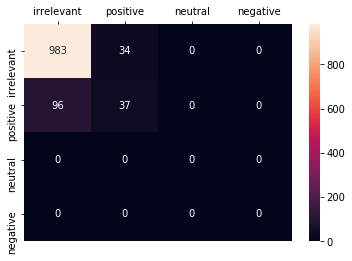

In [74]:
# 0=irrilevante, 1=positivo, 2=neutro, 3=negativo
print('F1 score on validation data: ' + str(f1_score(test_y_cf, pred_y_cf)))
print('Recall on validation data: ' + str(recall_score(test_y_cf, pred_y_cf)))
cm = confusion_matrix(test_y_cf, pred_y_cf, labels=[0, 1, 2, 3])
ax = sns.heatmap(cm, annot=True, xticklabels=['irrelevant','positive','neutral', 'negative'], yticklabels=['irrelevant','positive','neutral', 'negative'], fmt="d")
ax.xaxis.set_ticks_position('top')

Features selection. Plot by descending weight

The weight/coefficient matrix of a generalised linear model predictor, of shape (n_features,) for binary classification and single-output regression, (n_classes, n_features) for multiclass classification and (n_targets, n_features) for multi-output regression. Note this does not include the intercept (or bias) term, which is stored in intercept_.

When available, feature_importances_ is not usually provided as well, but can be calculated as the norm of each feature’s entry in coef_.

https://stats.stackexchange.com/questions/39243/how-does-one-interpret-svm-feature-weights

In [31]:
weights = clf.best_estimator_.coef_
print(weights.shape)
# 6 perchè fa un classifictore per ogni coppia di labels (ovr) -> verificare

(1, 188026)


In [32]:
print(weights.indices)
print(weights.data)

[179821 169914 169913 ...  48005  47763  45086]
[ 0.1977137   0.1977137   0.1977137  ... -0.00507185 -0.01481056
  0.04464791]


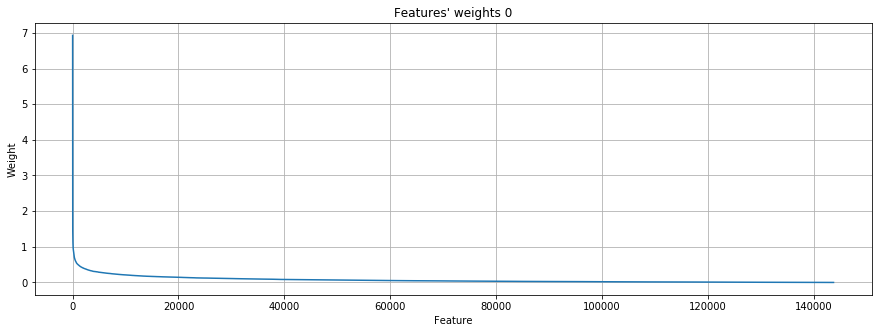

In [33]:
# Data for plotting
for i in range(weights.shape[0]):
    fig, ax = plt.subplots(figsize=(15,5))
    ax.plot(range(weights[i].data.shape[0]), sorted(abs(weights[i].data), reverse = True))
    ax.set(xlabel='Feature', ylabel='Weight', title='Features\' weights ' + str(i))
    ax.grid()
    #fig.savefig("test.png")
    plt.show()

In [34]:
# select most important features
cutoff_0 = 0.35
selected_features_0 = [i for i in sorted(zip(map(lambda x: round(x, 4), abs(weights[0].data)), weights[0].indices), reverse=True) if i[0] > cutoff_0]
#cutoff_1 = 0.15
# selected_features_1 = [i for i in sorted(zip(map(lambda x: round(x, 4), abs(weights[1].data)), weights[1].indices), reverse=True) if i[0] > cutoff_1]
# cutoff_2 = 0.15
# selected_features_2 = [i for i in sorted(zip(map(lambda x: round(x, 4), abs(weights[2].data)), weights[2].indices), reverse=True) if i[0] > cutoff_2]
# cutoff_3 = 0.15
# selected_features_3 = [i for i in sorted(zip(map(lambda x: round(x, 4), abs(weights[3].data)), weights[3].indices), reverse=True) if i[0] > cutoff_3]
# cutoff_4 = 0.15
# selected_features_4 = [i for i in sorted(zip(map(lambda x: round(x, 4), abs(weights[4].data)), weights[4].indices), reverse=True) if i[0] > cutoff_4]
# cutoff_5 = 0.15
# selected_features_5 = [i for i in sorted(zip(map(lambda x: round(x, 4), abs(weights[5].data)), weights[5].indices), reverse=True) if i[0] > cutoff_5]

In [35]:
# take the union of selected features (a word important for a classification may be not important for other classifications)
selected_features = set()
for f in selected_features_0:
    selected_features.add(f[1])
# for f in selected_features_1:
#     selected_features.add(f[1])
# for f in selected_features_2:
#     selected_features.add(f[1])
# for f in selected_features_3:
#     selected_features.add(f[1])
# for f in selected_features_4:
#     selected_features.add(f[1])
# for f in selected_features_5:
#     selected_features.add(f[1])
print('Selected ' + str(len(selected_features)) + ' features')    

Selected 2964 features


Now retry grid search using only selected features

In [36]:
train_X_selected = train_X[:, list(selected_features)]
train_y_selected = train_y

In [75]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=False)
svm_clf_selected = svm.SVC(kernel='linear', decision_function_shape='ovr', verbose=2, random_state=42)

tuned_parameters = {'C': np.logspace(-3, 3, 7),}

scores = ['recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf_selected = GridSearchCV(svm_clf_selected, tuned_parameters, cv=skf, n_jobs=-1, scoring=score, verbose=2)
    clf_selected.fit(train_X_selected, train_y_selected)

    print("Best parameters set found on development set:")
    print()
    print(clf_selected.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf_selected.cv_results_['mean_test_score']
    stds = clf_selected.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf_selected.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print()

# Tuning hyper-parameters for recall

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   10.3s finished


[LibSVM]Best parameters set found on development set:

{'C': 1000.0}

Grid scores on development set:

0.000 (+/-0.000) for {'C': 0.001}
0.000 (+/-0.000) for {'C': 0.01}
0.000 (+/-0.000) for {'C': 0.1}
0.047 (+/-0.049) for {'C': 1.0}
0.491 (+/-0.081) for {'C': 10.0}
0.584 (+/-0.071) for {'C': 100.0}
0.590 (+/-0.055) for {'C': 1000.0}



New confusion matrix

In [76]:
train_X_fs, test_X_fs, train_y_fs, test_y_fs = train_test_split(train_X_selected, train_y_selected, test_size=0.2, stratify=train_y_selected, random_state=42)

In [77]:
best_clf_fs = svm.SVC(kernel='linear', C=1000, decision_function_shape='ovr', verbose=2, random_state=42)
best_clf_fs.fit(train_X_fs, train_y_fs)

[LibSVM]

SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=42,
  shrinking=True, tol=0.001, verbose=2)

In [78]:
# predictions
pred_y_fs = best_clf_fs.predict(test_X_fs)

F1 score on validation data: 0.6448979591836735
Recall on validation data: 0.5939849624060151


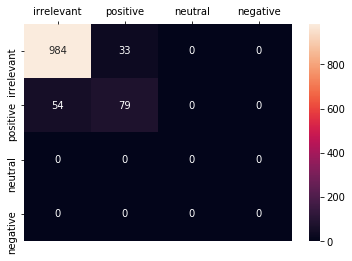

In [79]:
# 0=irrilevante, 1=positivo, 2=neutro, 3=negativo
print('F1 score on validation data: ' + str(f1_score(test_y_fs, pred_y_fs)))
print('Recall on validation data: ' + str(recall_score(test_y_fs, pred_y_fs)))
cm = confusion_matrix(test_y_fs, pred_y_fs, labels=[0, 1, 2, 3])
ax = sns.heatmap(cm, annot=True, xticklabels=['irrelevant','positive','neutral', 'negative'], yticklabels=['irrelevant','positive','neutral', 'negative'], fmt="d")
ax.xaxis.set_ticks_position('top')

Most important features

### 0


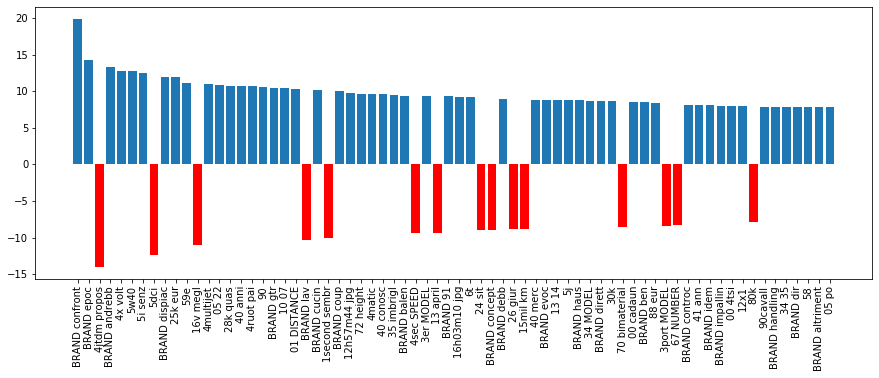

In [42]:
best_n = 70
feature_names = vec.get_feature_names()
for i in range(weights.shape[0]):
    print('### ' + str(i))
    fn = []
    fv = []
    f = [i for i in sorted(zip(map(lambda x: round(x, 4), clf_selected.best_estimator_.coef_[i].data), clf_selected.best_estimator_.coef_[i].indices), reverse=True, key=lambda k: abs(k[0]))][:best_n]
    for j in range(len(f)):
        fn.append(feature_names[f[j][1]])
        fv.append(f[j][0])
        #print(str(feature_names[f[j][1]]) + ': ' + str(f[j][0]))
    fig, ax = plt.subplots(figsize=(15,5))
    plt.bar([i for i in range(best_n) if fv[i]>0], [x for x in fv if x>0])
    plt.bar([i for i in range(best_n) if fv[i]<0], [x for x in fv if x<0], color='r')
    plt.xticks(range(best_n), fn, rotation='vertical')
    plt.show()

## Sentiment Classification

In [43]:
sentiment_dataset = original_dataset.copy()

Get only relevant rows

In [44]:
sentiment_dataset = sentiment_dataset.drop(sentiment_dataset[(sentiment_dataset[column] == 'irrilevante')].index).reset_index()
sentiment_dataset

,index,TESTO,(Testo Citato),Motore
0,11,Mah parleranno di ipotetiche versioni ibride o...,,negativo
1,13,SZ ES-30 ?,,neutro
2,17,Benvenuta nel posto giusto Allora sentirai div...,"""Buongiorno a tutti So che il titolo di questo...",neutro
3,18,Ma come c'è il gpl ! ! ! Ahahaha Nel 2010 se b...,,positivo
4,22,Hanno limiti di emissioni diversi come in Usa ...,,neutro
5,29,Per ora no rinviato a sabato prossimo,'ragazz scusate l OT e scusate se scrivo ben p...,positivo
6,36,Accorgimenti tecnici ma di base ( basamenti in...,,neutro
7,40,Non ho ancora ricevuto la risposta... e faccio...,,negativo
8,42,Buongiorno...rilancio con Renault.. Ho acquist...,,molto negativo
9,46,Ah la Cuore e' una Daia di piccola cilindrata....,,negativo


In [45]:
pp = Preprocessor()
# TESTO
for i in range(len(sentiment_dataset)):
    sentiment_dataset['TESTO'][i] = pp.preprocessText(sentiment_dataset['TESTO'][i], method='word', use_stemmer=True, ner=True)
# (Testo Citato)
for i in range(len(sentiment_dataset)):
    sentiment_dataset['(Testo Citato)'][i] = pp.preprocessText(sentiment_dataset['(Testo Citato)'][i], method='word', use_stemmer=True, ner=True)    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [46]:
# combine labels "molto positivo" = "positivo" and so on
sentiment_dataset[column] = sentiment_dataset[column].replace('molto positivo', 'positivo')
sentiment_dataset[column] = sentiment_dataset[column].replace('molto negativo', 'negativo')

In [47]:
collections.Counter(sentiment_dataset[column])

Counter({'negativo': 155, 'neutro': 358, 'positivo': 317})

Vectorization

In [48]:
preprocessed_dataset_sentiment = []
for i in range(len(sentiment_dataset)):
    preprocessed_dataset_sentiment.append((combine_text_quote(sentiment_dataset['TESTO'][i], sentiment_dataset['(Testo Citato)'][i], divide_quote=False), sentiment_dataset[column][i]))

In [49]:
numpy_dataset_sentiment = np.array(preprocessed_dataset_sentiment)
print('Length: ' + str(numpy_dataset_sentiment.shape[0]))

Length: 830


In [50]:
np.random.seed(42)
# split 80% training and 20% test
# FARLO RISPETTANDO LA DISTRIBUZIONE
np.random.shuffle(numpy_dataset_sentiment)
#numpy_dataset = numpy_dataset[perm]
#split = int(0.8 * numpy_dataset.shape[0])
#train_dataset, test_dataset = numpy_dataset[:split,:], numpy_dataset[split:,:]
train_dataset_X_sentiment, test_dataset_X_sentiment, train_dataset_y_sentiment, test_dataset_y_sentiment = train_test_split(numpy_dataset_sentiment[:,0], numpy_dataset_sentiment[:,1], test_size=0.2, stratify=numpy_dataset_sentiment[:,1], random_state=42)

In [51]:
train_dataset_X_sentiment.shape[0]

664

In [52]:
# VECTORIZE
vec_sentiment = TfidfVectorizer(ngram_range=(1,2), lowercase=False)
#train_dataset_X = vec.fit_transform(train_dataset_X)

# final dataset for the classification
train_X_sentiment = vec_sentiment.fit_transform(train_dataset_X_sentiment)
train_y_sentiment = np.empty([train_dataset_y_sentiment.shape[0], 1]).ravel()

for i in range(train_dataset_y_sentiment.shape[0]):
    if train_dataset_y_sentiment[i] == 'positivo':
        train_y_sentiment[i] = 0
    elif train_dataset_y_sentiment[i] == 'neutro':
        train_y_sentiment[i] = 1
    elif train_dataset_y_sentiment[i] == 'negativo':
        train_y_sentiment[i] = 2

In [53]:
collections.Counter(train_y_sentiment)

Counter({1.0: 286, 0.0: 254, 2.0: 124})

SVM_TFIDF_Classifier without feaure selection

In [80]:
skf_sentiment = StratifiedKFold(n_splits=5, random_state=42, shuffle=False)
svm_clf_sentiment = svm.SVC(kernel='linear', decision_function_shape='ovr', verbose=2, random_state=42)

tuned_parameters = {'C': np.logspace(-3, 3, 7),}

# f1, f1_macro (for multiclass), recall
scores = ['f1_micro']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf_sentiment = GridSearchCV(svm_clf_sentiment, tuned_parameters, cv=skf_sentiment, n_jobs=-1, scoring=score, verbose=2)
    clf_sentiment.fit(train_X_sentiment, train_y_sentiment)

    print("Best parameters set found on development set:")
    print()
    print(clf_sentiment.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf_sentiment.cv_results_['mean_test_score']
    stds = clf_sentiment.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf_sentiment.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print()

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    3.2s finished


[LibSVM]Best parameters set found on development set:

{'C': 10.0}

Grid scores on development set:

0.431 (+/-0.005) for {'C': 0.001}
0.431 (+/-0.005) for {'C': 0.01}
0.431 (+/-0.005) for {'C': 0.1}
0.494 (+/-0.069) for {'C': 1.0}
0.497 (+/-0.044) for {'C': 10.0}
0.497 (+/-0.044) for {'C': 100.0}
0.497 (+/-0.044) for {'C': 1000.0}



In [81]:
train_X_cf_sentiment, test_X_cf_sentiment, train_y_cf_sentiment, test_y_cf_sentiment = train_test_split(train_X_sentiment, train_y_sentiment, test_size=0.2, stratify=train_y_sentiment, random_state=42)

In [82]:
best_clf_sentiment = svm.SVC(kernel='linear', C=clf_sentiment.best_params_['C'], decision_function_shape='ovr', verbose=2, random_state=42)
best_clf_sentiment.fit(train_X_cf_sentiment, train_y_cf_sentiment)

[LibSVM]

SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=42,
  shrinking=True, tol=0.001, verbose=2)

In [83]:
# predictions
pred_y_cf_sentiment = best_clf_sentiment.predict(test_X_cf_sentiment)

F1 score micro on validation data: 0.5037593984962406


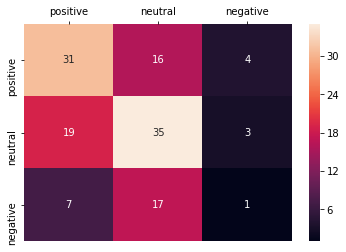

In [84]:
# 0=positivo, 1=neutro, 2=negativo
print('F1 score micro on validation data: ' + str(f1_score(test_y_cf_sentiment, pred_y_cf_sentiment, average='micro')))
cm_sentiment = confusion_matrix(test_y_cf_sentiment, pred_y_cf_sentiment, labels=[0, 1, 2])
ax = sns.heatmap(cm_sentiment, annot=True, xticklabels=['positive','neutral','negative'], yticklabels=['positive','neutral','negative'])
ax.xaxis.set_ticks_position('top')

Feature Selection

In [85]:
weights_sentiment = clf_sentiment.best_estimator_.coef_
print(weights.shape)
# 6 perchè fa un classifictore per ogni coppia di labels (ovr) -> verificare

(1, 188026)


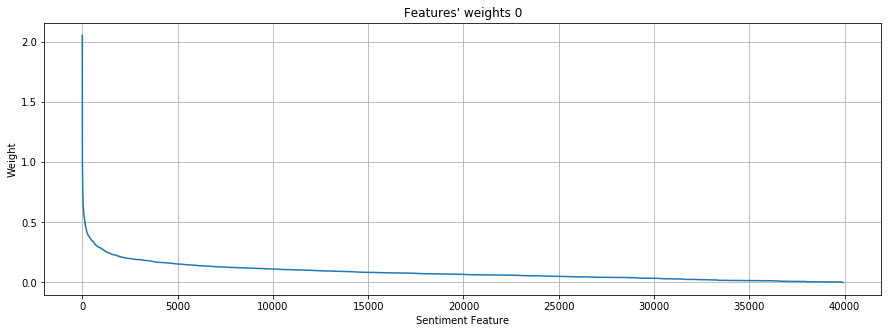

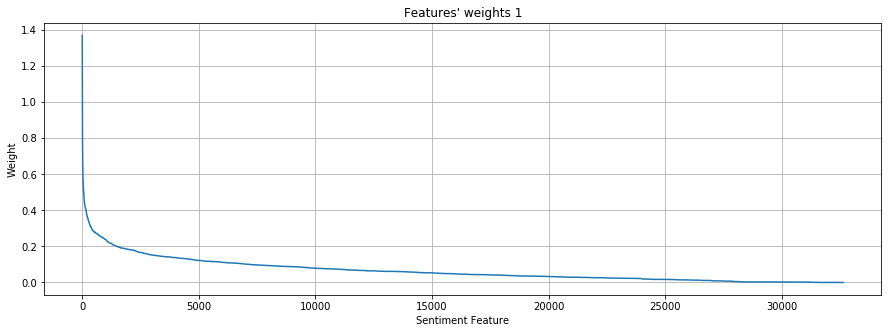

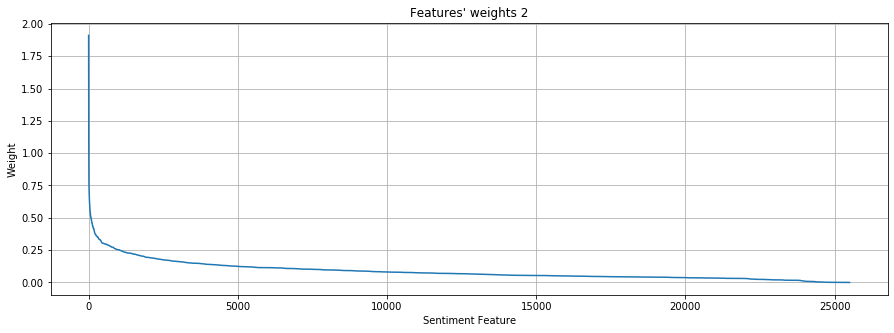

In [86]:
# Data for plotting
for i in range(weights_sentiment.shape[0]):
    fig, ax = plt.subplots(figsize=(15,5))
    ax.plot(range(weights_sentiment[i].data.shape[0]), sorted(abs(weights_sentiment[i].data), reverse = True))
    ax.set(xlabel='Sentiment Feature', ylabel='Weight', title='Features\' weights ' + str(i))
    ax.grid()
    #fig.savefig("test.png")
    plt.show()

In [87]:
# select most important features
cutoff_0 = 0.15
selected_features_sentiment_0 = [i for i in sorted(zip(map(lambda x: round(x, 4), abs(weights_sentiment[0].data)), weights_sentiment[0].indices), reverse=True) if i[0] > cutoff_0]
cutoff_1 = 0.1
selected_features_sentiment_1 = [i for i in sorted(zip(map(lambda x: round(x, 4), abs(weights_sentiment[1].data)), weights_sentiment[1].indices), reverse=True) if i[0] > cutoff_1]
cutoff_2 = 0.15
selected_features_sentiment_2 = [i for i in sorted(zip(map(lambda x: round(x, 4), abs(weights_sentiment[2].data)), weights_sentiment[2].indices), reverse=True) if i[0] > cutoff_2]

In [88]:
# take the union of selected features (a word important for a classification may be not important for other classifications)
selected_features_sentiment = set()
for f in selected_features_sentiment_0:
    selected_features_sentiment.add(f[1])
for f in selected_features_sentiment_1:
    selected_features_sentiment.add(f[1])
for f in selected_features_sentiment_2:
    selected_features_sentiment.add(f[1])
print('Selected ' + str(len(selected_features_sentiment)) + ' features')    

Selected 10474 features


Retry with selected features

In [89]:
train_X_selected_sentiment = train_X_sentiment[:, list(selected_features_sentiment)]
train_y_selected_sentiment = train_y_sentiment

In [90]:
skf_sentiment = StratifiedKFold(n_splits=5, random_state=42, shuffle=False)
svm_clf_selected_sentiment = svm.SVC(kernel='linear', decision_function_shape='ovr', verbose=2, random_state=42)

tuned_parameters = {'C': np.logspace(-3, 3, 7),}

scores = ['f1_micro']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf_selected_sentiment = GridSearchCV(svm_clf_selected, tuned_parameters, cv=skf_sentiment, n_jobs=-1, scoring=score, verbose=2)
    clf_selected_sentiment.fit(train_X_selected_sentiment, train_y_selected_sentiment)

    print("Best parameters set found on development set:")
    print()
    print(clf_selected_sentiment.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf_selected_sentiment.cv_results_['mean_test_score']
    stds = clf_selected_sentiment.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf_selected.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print()

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    2.8s finished


[LibSVM]Best parameters set found on development set:

{'C': 10.0}

Grid scores on development set:

0.431 (+/-0.005) for {'C': 0.001}
0.431 (+/-0.005) for {'C': 0.01}
0.431 (+/-0.005) for {'C': 0.1}
0.523 (+/-0.080) for {'C': 1.0}
0.580 (+/-0.031) for {'C': 10.0}
0.580 (+/-0.031) for {'C': 100.0}
0.580 (+/-0.031) for {'C': 1000.0}



In [91]:
train_X_fs_sentiment, test_X_fs_sentiment, train_y_fs_sentiment, test_y_fs_sentiment = train_test_split(train_X_selected_sentiment, train_y_selected_sentiment, test_size=0.2, stratify=train_y_selected_sentiment, random_state=42)

In [92]:
best_clf_fs_sentiment = svm.SVC(kernel='linear', C=clf_selected_sentiment.best_params_['C'], decision_function_shape='ovr', verbose=2, random_state=42)
best_clf_fs_sentiment.fit(train_X_fs_sentiment, train_y_fs_sentiment)

[LibSVM]

SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=42,
  shrinking=True, tol=0.001, verbose=2)

In [93]:
# predictions
pred_y_fs_sentiment = best_clf_fs_sentiment.predict(test_X_fs_sentiment)

F1 micro score on validation data: 0.5864661654135338


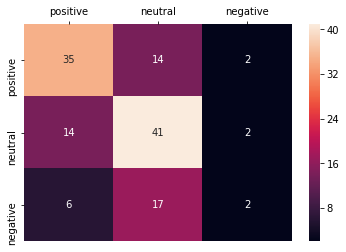

In [94]:
# 0=positivo, 1=neutro, 2=negativo
print('F1 micro score on validation data: ' + str(f1_score(test_y_fs_sentiment, pred_y_fs_sentiment, average='micro')))
cm_sentiment = confusion_matrix(test_y_fs_sentiment, pred_y_fs_sentiment, labels=[0, 1, 2])
ax = sns.heatmap(cm_sentiment, annot=True, xticklabels=['positive','neutral','negative'], yticklabels=['positive','neutral','negative'])
ax.xaxis.set_ticks_position('top')

### 0


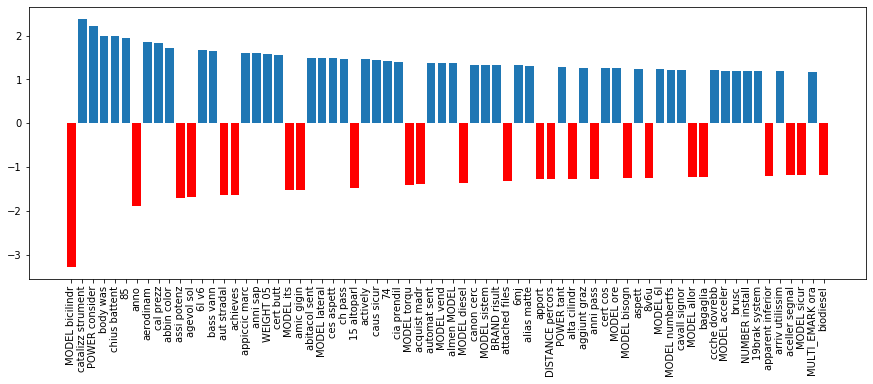

### 1


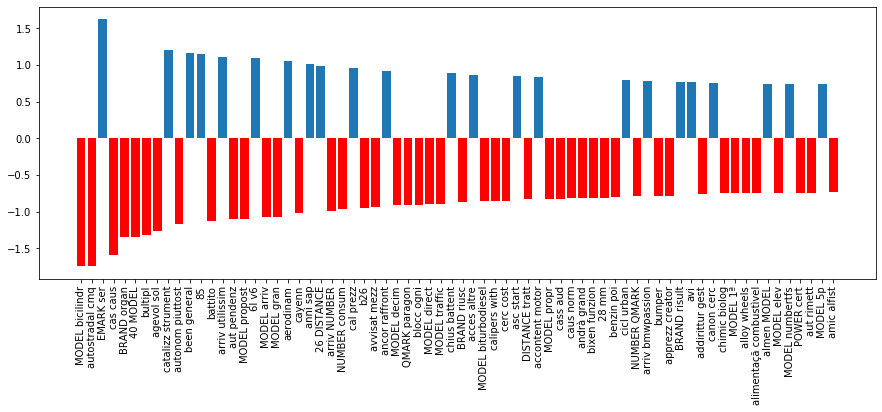

### 2


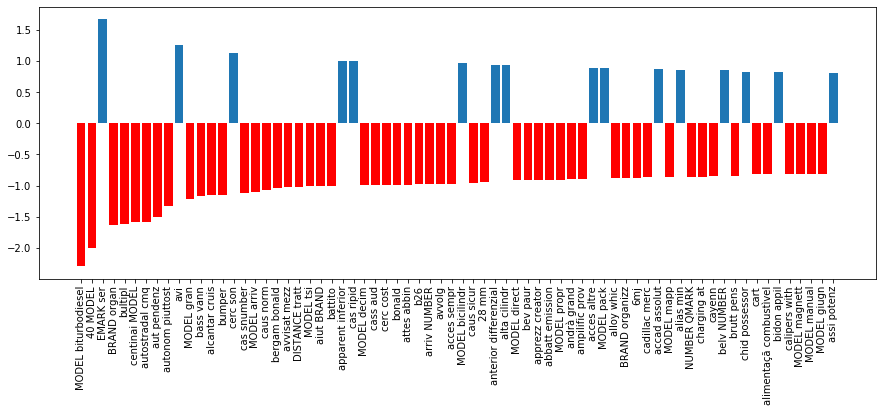

In [95]:
best_n = 70
feature_names_sentiment = vec_sentiment.get_feature_names()
for i in range(weights_sentiment.shape[0]):
    print('### ' + str(i))
    fn_sentiment = []
    fv_sentiment = []
    f_sentiment = [i for i in sorted(zip(map(lambda x: round(x, 4), clf_selected_sentiment.best_estimator_.coef_[i].data), clf_selected_sentiment.best_estimator_.coef_[i].indices), reverse=True, key=lambda k: abs(k[0]))][:best_n]
    for j in range(len(f_sentiment)):
        fn_sentiment.append(feature_names_sentiment[f_sentiment[j][1]])
        fv_sentiment.append(f_sentiment[j][0])
        #print(str(feature_names[f[j][1]]) + ': ' + str(f[j][0]))
    fig, ax = plt.subplots(figsize=(15,5))
    plt.bar([i for i in range(best_n) if fv_sentiment[i]>0], [x for x in fv_sentiment if x>0])
    plt.bar([i for i in range(best_n) if fv_sentiment[i]<0], [x for x in fv_sentiment if x<0], color='r')
    plt.xticks(range(best_n), fn_sentiment, rotation='vertical')
    plt.show()

## Classification with 4 labels

In [131]:
dataset_complete = original_dataset.copy()
dataset_complete

,TESTO,(Testo Citato),Motore
0,Allora il problema è che non sono aggiornati i...,,irrilevante
1,E' virgolettato appositamente.... E soprattutt...,,irrilevante
2,Mah io sulla mappa ev-way ho visto solo tipo 2...,'Inferiore non s ma probabilmente uguale (il m...,irrilevante
3,Ah però.... uno pensa di averne viste tante su...,Sinceramente una differenza di 9.800? non mi p...,irrilevante
4,Basta darsi delle regole e per questo tipo di ...,,irrilevante
5,Personalmente posso ritenermi un possessore di...,,irrilevante
6,Confermo che il posteriore è riuscitissimo e a...,"""sono stato anch'io in conce per altri motivi ...",irrilevante
7,Mi sa che l'unica cosa apprezzabile del rst è ...,,irrilevante
8,grazie ! ! ! ! !,,irrilevante
9,Cosimo hai centrato completamente,,irrilevante


Preprocessing

In [132]:
pp = Preprocessor()
# TESTO
for i in range(len(dataset)):
    dataset_complete['TESTO'][i] = pp.preprocessText(dataset_complete['TESTO'][i], method='word', use_stemmer=True, ner=True)
# (Testo Citato)
for i in range(len(dataset)):
    dataset_complete['(Testo Citato)'][i] = pp.preprocessText(dataset_complete['(Testo Citato)'][i], method='word', use_stemmer=True, ner=True)    

In [133]:
# combine labels "molto positivo" = "positivo" and so on
dataset_complete[column] = dataset_complete[column].replace('molto positivo', 'positivo')
dataset_complete[column] = dataset_complete[column].replace('molto negativo', 'negativo')

Vectorization

In [134]:
preprocessed_dataset_complete = []
for i in range(len(dataset_complete)):
    preprocessed_dataset_complete.append((combine_text_quote(dataset_complete['TESTO'][i], dataset_complete['(Testo Citato)'][i], divide_quote=False), dataset_complete[column][i]))

In [135]:
preprocessed_dataset_complete[50]

('MODEL nessun chied dir fals chied sol difend indifend strateg EMARK ok dic ver dubit incazz best urland te dietr sopr sott camb EMARK MODEL camb EMARK fabv BRAND bisogn ( avvoc ) difensor bisogn attacc EMARK usat avvoc finor success raggiung strabil svolg compitin insegu lont concorrt EMARK twisted twisted twisted twisted twisted',
 'irrilevante')

Split into training and test

In [136]:
numpy_dataset_complete = np.array(preprocessed_dataset_complete)
print('Length: ' + str(numpy_dataset_complete.shape[0]))

Length: 7183


In [137]:
np.random.seed(42)
# split 80% training and 20% test
# FARLO RISPETTANDO LA DISTRIBUZIONE
np.random.shuffle(numpy_dataset_complete)
#numpy_dataset = numpy_dataset[perm]
#split = int(0.8 * numpy_dataset.shape[0])
#train_dataset, test_dataset = numpy_dataset[:split,:], numpy_dataset[split:,:]
train_dataset_X_complete, test_dataset_X_complete, train_dataset_y_complete, test_dataset_y_complete = train_test_split(numpy_dataset_complete[:,0], numpy_dataset_complete[:,1], test_size=0.2, stratify=numpy_dataset_complete[:,1], random_state=42)

In [138]:
train_dataset_X_complete.shape

(5746,)

Some statistics

In [139]:
collections.Counter(train_dataset_y_complete)

Counter({'irrilevante': 5082, 'negativo': 124, 'positivo': 254, 'neutro': 286})

Finally replace text with vector, and replace label with numerical representation

In [140]:
# VECTORIZE
vec_complete = TfidfVectorizer(ngram_range=(1,2), lowercase=False)
#train_dataset_X = vec.fit_transform(train_dataset_X)

# final dataset for the classification
train_X_complete = vec_complete.fit_transform(train_dataset_X_complete)
train_y_complete = np.empty([train_dataset_y_complete.shape[0], 1]).ravel()

for i in range(train_dataset_y_complete.shape[0]):
    if train_dataset_y_complete[i] == 'irrilevante':
        train_y_complete[i] = 0
    elif train_dataset_y_complete[i] == 'positivo':
        train_y_complete[i] = 1
    elif train_dataset_y_complete[i] == 'neutro':
        train_y_complete[i] = 2
    elif train_dataset_y_complete[i] == 'negativo':
        train_y_complete[i] = 3

SVM _TFIDF Classifier

In [141]:
skf_complete = StratifiedKFold(n_splits=5, random_state=42, shuffle=False)
svm_clf_complete = svm.SVC(kernel='linear', decision_function_shape='ovr', verbose=2, random_state=42)

tuned_parameters = {'C': np.logspace(-3, 3, 7),}

# f1, f1_macro (for multiclass), recall
scores = ['f1_macro']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf_complete = GridSearchCV(svm_clf_complete, tuned_parameters, cv=skf_complete, n_jobs=-1, scoring=score, verbose=2)
    clf_complete.fit(train_X_complete, train_y_complete)

    print("Best parameters set found on development set:")
    print()
    print(clf_complete.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf_complete.cv_results_['mean_test_score']
    stds = clf_complete.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf_complete.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print()

# Tuning hyper-parameters for f1_macro

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:  2.4min finished


[LibSVM]Best parameters set found on development set:

{'C': 100.0}

Grid scores on development set:

0.235 (+/-0.000) for {'C': 0.001}
0.235 (+/-0.000) for {'C': 0.01}
0.235 (+/-0.000) for {'C': 0.1}
0.249 (+/-0.032) for {'C': 1.0}
0.290 (+/-0.036) for {'C': 10.0}
0.299 (+/-0.046) for {'C': 100.0}
0.299 (+/-0.046) for {'C': 1000.0}



Refit with best parameters and then draw confusion matrix on validation data

In [142]:
train_X_cf_complete, test_X_cf_complete, train_y_cf_complete, test_y_cf_complete = train_test_split(train_X_complete, train_y_complete, test_size=0.2, stratify=train_y_complete, random_state=42)

In [143]:
best_clf_complete = svm.SVC(kernel='linear', C=clf_complete.best_params_['C'], decision_function_shape='ovr', verbose=2, random_state=42)
best_clf_complete.fit(train_X_cf_complete, train_y_cf_complete)

[LibSVM]

SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=42,
  shrinking=True, tol=0.001, verbose=2)

In [144]:
# predictions
pred_y_cf_complete = best_clf_complete.predict(test_X_cf_complete)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


F1 macro score on validation data: 0.31171413338578324


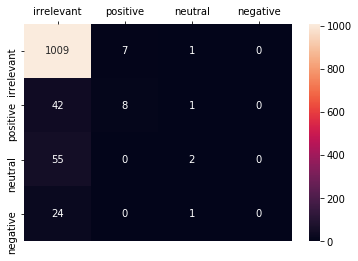

In [145]:
# 0=irrilevante, 1=positivo, 2=neutro, 3=negativo
print('F1 macro score on validation data: ' + str(f1_score(test_y_cf_complete, pred_y_cf_complete, average='macro')))
cm_complete = confusion_matrix(test_y_cf_complete, pred_y_cf_complete, labels=[0, 1, 2, 3])
ax = sns.heatmap(cm_complete, annot=True, xticklabels=['irrelevant','positive','neutral', 'negative'], yticklabels=['irrelevant','positive','neutral', 'negative'], fmt="d")
ax.xaxis.set_ticks_position('top')

Features selection. Plot by descending weight


In [146]:
weights_complete = clf_complete.best_estimator_.coef_
print(weights_complete.shape)
# 6 perchè fa un classifictore per ogni coppia di labels (ovr) -> verificare

(6, 188026)


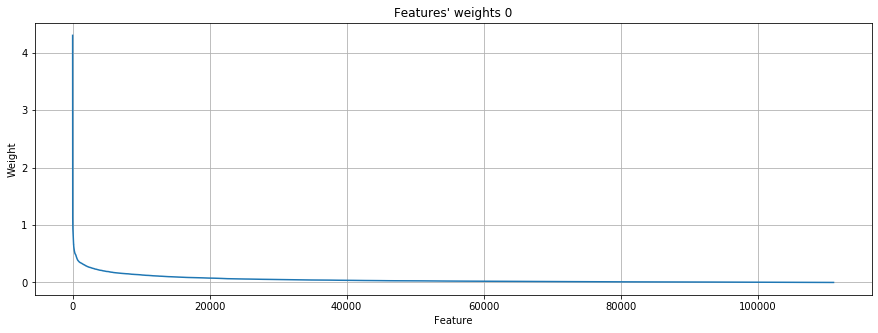

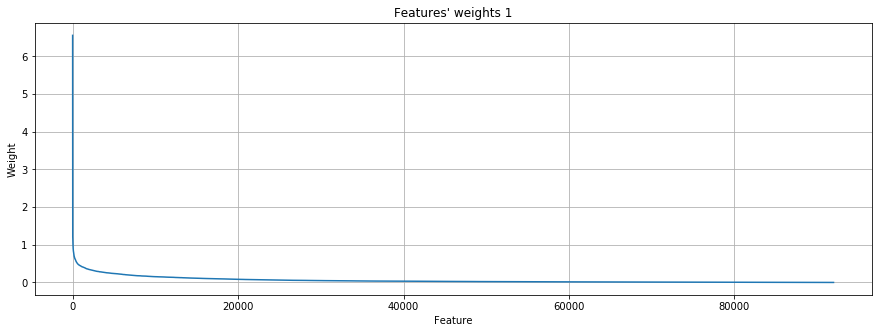

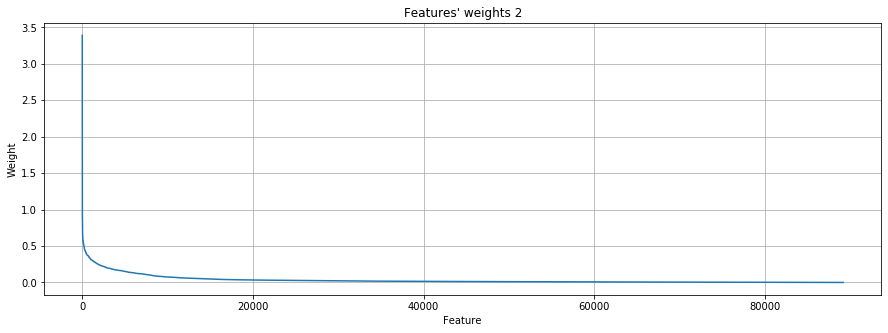

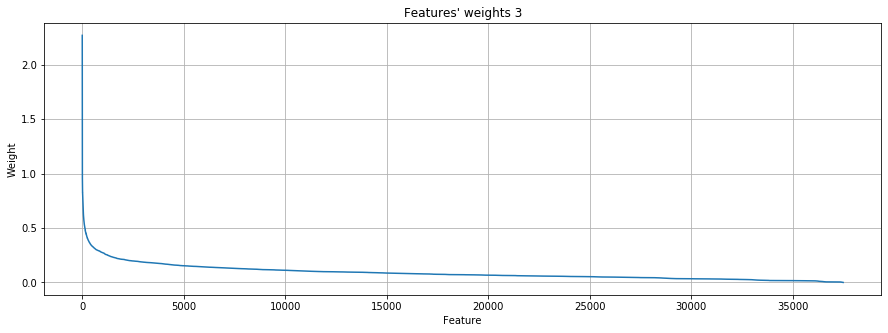

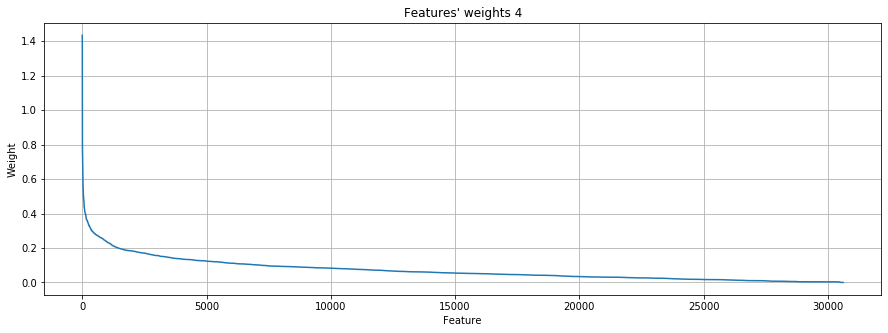

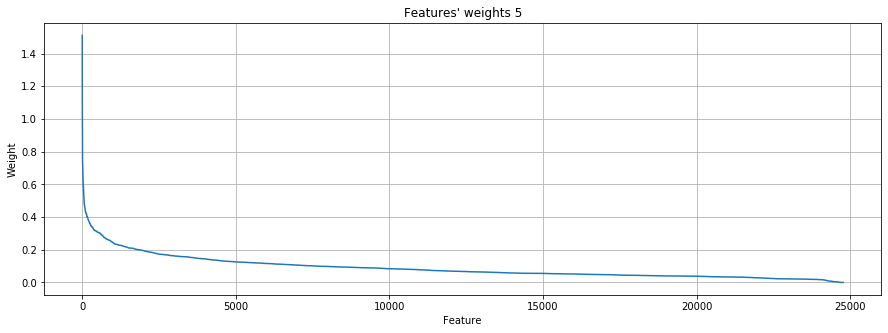

In [147]:
# Data for plotting
for i in range(weights_complete.shape[0]):
    fig, ax = plt.subplots(figsize=(15,5))
    ax.plot(range(weights_complete[i].data.shape[0]), sorted(abs(weights_complete[i].data), reverse = True))
    ax.set(xlabel='Feature', ylabel='Weight', title='Features\' weights ' + str(i))
    ax.grid()
    #fig.savefig("test.png")
    plt.show()

In [148]:
# select most important features
cutoff_0 = 0.15
selected_features_complete_0 = [i for i in sorted(zip(map(lambda x: round(x, 4), abs(weights_complete[0].data)), weights_complete[0].indices), reverse=True) if i[0] > cutoff_0]
cutoff_1 = 0.15
selected_features_complete_1 = [i for i in sorted(zip(map(lambda x: round(x, 4), abs(weights_complete[1].data)), weights_complete[1].indices), reverse=True) if i[0] > cutoff_1]
cutoff_2 = 0.15
selected_features_complete_2 = [i for i in sorted(zip(map(lambda x: round(x, 4), abs(weights_complete[2].data)), weights_complete[2].indices), reverse=True) if i[0] > cutoff_2]
cutoff_3 = 0.15
selected_features_complete_3 = [i for i in sorted(zip(map(lambda x: round(x, 4), abs(weights_complete[3].data)), weights_complete[3].indices), reverse=True) if i[0] > cutoff_3]
cutoff_4 = 0.15
selected_features_complete_4 = [i for i in sorted(zip(map(lambda x: round(x, 4), abs(weights_complete[4].data)), weights_complete[4].indices), reverse=True) if i[0] > cutoff_4]
cutoff_5 = 0.15
selected_features_complete_5 = [i for i in sorted(zip(map(lambda x: round(x, 4), abs(weights_complete[5].data)), weights_complete[5].indices), reverse=True) if i[0] > cutoff_5]

In [149]:
# take the union of selected features (a word important for a classification may be not important for other classifications)
selected_features_complete = set()
for f in selected_features_complete_0:
    selected_features_complete.add(f[1])
for f in selected_features_complete_1:
    selected_features_complete.add(f[1])
for f in selected_features_complete_2:
    selected_features_complete.add(f[1])
for f in selected_features_complete_3:
    selected_features_complete.add(f[1])
for f in selected_features_complete_4:
    selected_features_complete.add(f[1])
for f in selected_features_complete_5:
    selected_features_complete.add(f[1])
print('Selected ' + str(len(selected_features_complete)) + ' features')    

Selected 21823 features


Now retry grid search using only selected features

In [150]:
train_X_selected_complete = train_X_complete[:, list(selected_features_complete)]
train_y_selected_complete = train_y_complete

In [151]:
skf_complete = StratifiedKFold(n_splits=5, random_state=42, shuffle=False)
svm_clf_selected_complete = svm.SVC(kernel='linear', decision_function_shape='ovr', verbose=2, random_state=42)

tuned_parameters = {'C': np.logspace(-3, 3, 7),}

scores = ['f1_macro']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf_selected_complete = GridSearchCV(svm_clf_selected_complete, tuned_parameters, cv=skf_complete, n_jobs=-1, scoring=score, verbose=2)
    clf_selected_complete.fit(train_X_selected_complete, train_y_selected_complete)

    print("Best parameters set found on development set:")
    print()
    print(clf_selected_complete.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf_selected_complete.cv_results_['mean_test_score']
    stds = clf_selected_complete.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf_selected_complete.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print()

# Tuning hyper-parameters for f1_macro

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   49.2s finished


[LibSVM]Best parameters set found on development set:

{'C': 100.0}

Grid scores on development set:

0.235 (+/-0.000) for {'C': 0.001}
0.235 (+/-0.000) for {'C': 0.01}
0.235 (+/-0.000) for {'C': 0.1}
0.235 (+/-0.000) for {'C': 1.0}
0.310 (+/-0.022) for {'C': 10.0}
0.321 (+/-0.032) for {'C': 100.0}
0.320 (+/-0.028) for {'C': 1000.0}



New confusion matrix

In [152]:
train_X_fs_complete, test_X_fs_complete, train_y_fs_complete, test_y_fs_complete = train_test_split(train_X_selected_complete, train_y_selected_complete, test_size=0.2, stratify=train_y_selected_complete, random_state=42)

In [153]:
best_clf_fs_complete = svm.SVC(kernel='linear', C=clf_selected_complete.best_params_['C'], decision_function_shape='ovr', verbose=2, random_state=42)
best_clf_fs_complete.fit(train_X_fs_complete, train_y_fs_complete)

[LibSVM]

SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=42,
  shrinking=True, tol=0.001, verbose=2)

In [154]:
# predictions
pred_y_fs_complete = best_clf_fs_complete.predict(test_X_fs_complete)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


F1 macro score on validation data: 0.3407524168648617


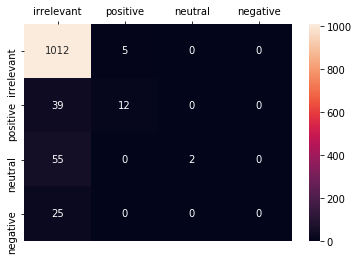

In [155]:
# 0=irrilevante, 1=positivo, 2=neutro, 3=negativo
print('F1 macro score on validation data: ' + str(f1_score(test_y_fs_complete, pred_y_fs_complete, average='macro')))
cm = confusion_matrix(test_y_fs_complete, pred_y_fs_complete, labels=[0, 1, 2, 3])
ax = sns.heatmap(cm, annot=True, xticklabels=['irrelevant','positive','neutral', 'negative'], yticklabels=['irrelevant','positive','neutral', 'negative'], fmt="d")
ax.xaxis.set_ticks_position('top')

Most important features

### 0


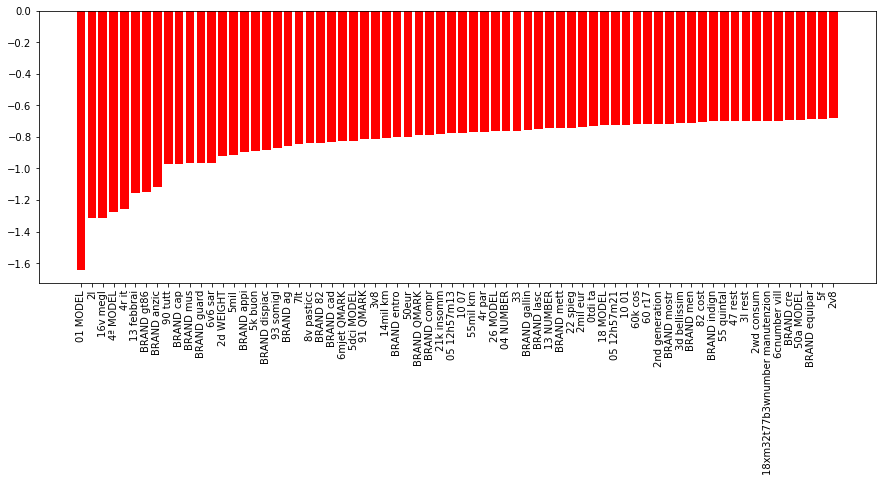

In [156]:
best_n = 70
feature_names_complete = vec_complete.get_feature_names()
for i in range(weights.shape[0]):
    print('### ' + str(i))
    fn = []
    fv = []
    f = [i for i in sorted(zip(map(lambda x: round(x, 4), clf_selected_complete.best_estimator_.coef_[i].data), clf_selected.best_estimator_.coef_[i].indices), reverse=True, key=lambda k: abs(k[0]))][:best_n]
    for j in range(len(f)):
        fn.append(feature_names_complete[f[j][1]])
        fv.append(f[j][0])
        #print(str(feature_names[f[j][1]]) + ': ' + str(f[j][0]))
    fig, ax = plt.subplots(figsize=(15,5))
    plt.bar([i for i in range(best_n) if fv[i]>0], [x for x in fv if x>0])
    plt.bar([i for i in range(best_n) if fv[i]<0], [x for x in fv if x<0], color='r')
    plt.xticks(range(best_n), fn, rotation='vertical')
    plt.show()